In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the datasets
boiler_input_df = pd.read_csv('boilerinput.csv')
coal_df = pd.read_csv('coaldf.csv')
boiler_output_df = pd.read_csv('boileroutput.csv')


In [2]:
# Merge datasets
merged_df = pd.merge(boiler_input_df, coal_df, on="time", how="inner")
merged_df = pd.merge(merged_df, boiler_output_df, on="time", how="inner")

# Drop rows with missing values for the required features
data = merged_df.dropna(subset=['Boiler Efficiency', 'Loss Due To H2 O In Fuel', 'Loss Due To Dry Flue Gas'])

# Define features for each objective
X = data[['Main Steam Flow', 'PRIMARY AIR FLOW', 'Sulphur in Fuel', 'Moisture in Fuel', 
          'Hydrogen In Fuel', 'GCV', 'SECOND AIR FLOW TOTAL']]

# Boiler Efficiency as the target variable for efficiency prediction
y_efficiency = data['Boiler Efficiency']

# Operational cost and emissions are assumed to be related to fuel loss (simplified)
y_cost = data['Loss Due To H2 O In Fuel'] + data['Loss Due To Dry Flue Gas']  # Example cost function
y_emissions = data['Loss Due To H2 In Fuel'] + data['Loss Due To Radiation']  # Example emissions


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_eff_train, y_eff_test = train_test_split(X, y_efficiency, test_size=0.2, random_state=42)
_, _, y_cost_train, y_cost_test = train_test_split(X, y_cost, test_size=0.2, random_state=42)
_, _, y_emissions_train, y_emissions_test = train_test_split(X, y_emissions, test_size=0.2, random_state=42)

# Train a Linear Regression model for Boiler Efficiency prediction
efficiency_model = LinearRegression()
efficiency_model.fit(X_train, y_eff_train)

# Train a Support Vector Regression model for Operational Cost prediction
cost_model = SVR(kernel='rbf', C=100, epsilon=0.1)
cost_model.fit(X_train, y_cost_train)

# Train a Neural Network model for Emission prediction
emissions_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
emissions_model.fit(X_train, y_emissions_train)


MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

In [4]:
# Define the multi-objective optimization function
def multi_objective(params):
    coal_flow, air_flow = params
    # Predict the objectives using the trained models
    efficiency = efficiency_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]  # Simplified input
    cost = cost_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]
    emissions = emissions_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]

    # We will use a weighted sum of the objectives (maximize efficiency, minimize cost, minimize emissions)
    efficiency_weight = 1.0
    cost_weight = -0.5  # Negative because we want to minimize cost
    emissions_weight = -0.3  # Negative because we want to minimize emissions

    # Combined objective function
    objective_value = (efficiency_weight * efficiency) + (cost_weight * cost) + (emissions_weight * emissions)
    return -objective_value  # Minimize the negative of the objective value


In [6]:
# Define bounds for coal flow and air flow
x0_bounds = (0, 679)  # Bounds for coal flow
x1_bounds = (0, 300)  # Bounds for air flow

# Perform multi-objective optimization using the Weighted Sum Method
result = minimize(multi_objective, [500, 500], bounds=[x0_bounds, x1_bounds], method='L-BFGS-B')

# Extract the optimal values for coal flow and air flow
optimal_coal_flow, optimal_air_flow = result.x
print(f"Optimized Coal Flow: {optimal_coal_flow}")
print(f"Optimized Air Flow: {optimal_air_flow}")


Optimized Coal Flow: 679.0
Optimized Air Flow: 0.0


c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ML

Updated solution as airflow was 0

In [7]:
# Step 5: Define the multi-objective optimization function with updated bounds
def multi_objective(params):
    coal_flow, air_flow = params
    # Predict the objectives using the trained models
    efficiency = efficiency_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]  # Simplified input
    cost = cost_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]
    emissions = emissions_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]

    # We will use a weighted sum of the objectives (maximize efficiency, minimize cost, minimize emissions)
    efficiency_weight = 1.0
    cost_weight = -0.5  # Negative because we want to minimize cost
    emissions_weight = -0.3  # Negative because we want to minimize emissions

    # Combined objective function
    objective_value = (efficiency_weight * efficiency) + (cost_weight * cost) + (emissions_weight * emissions)
    return -objective_value  # Minimize the negative of the objective value

# Step 6: Apply multi-objective optimization with updated bounds
x0_bounds = (0, 1000)  # Bounds for coal flow
x1_bounds = (100, 1000)  # Bounds for air flow (no zero air flow)

# Perform multi-objective optimization using the Weighted Sum Method
result = minimize(multi_objective, [500, 300], bounds=[x0_bounds, x1_bounds], method='L-BFGS-B')

# Extract the optimal values for coal flow and air flow
optimal_coal_flow, optimal_air_flow = result.x
print(f"Optimized Coal Flow: {optimal_coal_flow}")
print(f"Optimized Air Flow: {optimal_air_flow}")


Optimized Coal Flow: 1000.0
Optimized Air Flow: 100.0


c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ML

### Realistic Operational Constraints:

Coal Flow (CF) should be between 500 and 1000 kg/h (based on operational limits).

Air Flow (AF) should be between 200 and 800 kg/h (to ensure sufficient combustion air while preventing excess).

Air-to-Fuel Ratio (AFR) should be optimized to avoid excessive or insufficient air, typically between 1.1 and 2.2 (depending on combustion efficiency).

In [8]:
# Step 1: Import necessary libraries
import numpy as np
from scipy.optimize import minimize

# Step 2: Define realistic prediction models
# These would be models already trained on the dataset, which predict efficiency, cost, and emissions
# For this example, we'll simulate the models as simple functions.

def efficiency_model(coal_flow, air_flow):
    # Efficiency increases with coal flow and air flow, but too much coal or air reduces efficiency
    return 90 - 0.05 * (coal_flow - 700)**2 - 0.03 * (air_flow - 500)**2

def cost_model(coal_flow, air_flow):
    # Cost increases linearly with coal flow
    return 0.05 * coal_flow + 0.1 * air_flow

def emissions_model(coal_flow, air_flow):
    # Emissions are higher with excessive coal or air flow
    return 0.01 * coal_flow + 0.02 * air_flow

# Step 3: Define the multi-objective optimization function
def multi_objective(params):
    coal_flow, air_flow = params
    
    # Predict the objectives using the models
    efficiency = efficiency_model(coal_flow, air_flow)
    cost = cost_model(coal_flow, air_flow)
    emissions = emissions_model(coal_flow, air_flow)
    
    # Normalize efficiency (maximize), cost (minimize), and emissions (minimize)
    efficiency_weight = 1.0
    cost_weight = -0.5  # Negative because we want to minimize cost
    emissions_weight = -0.3  # Negative because we want to minimize emissions
    
    # Combine objectives with weighted sum
    objective_value = (efficiency_weight * efficiency) + (cost_weight * cost) + (emissions_weight * emissions)
    
    return -objective_value  # We minimize the negative value

# Step 4: Apply optimization with realistic bounds
# Coal flow between 500 and 1000 kg/h
# Air flow between 200 and 800 kg/h
x0_bounds = (500, 1000)  # Bounds for coal flow
x1_bounds = (200, 800)  # Bounds for air flow

# Perform multi-objective optimization using the Weighted Sum Method
result = minimize(multi_objective, [700, 500], bounds=[x0_bounds, x1_bounds], method='L-BFGS-B')

# Step 5: Extract and display the optimal values
optimal_coal_flow, optimal_air_flow = result.x
print(f"Optimized Coal Flow: {optimal_coal_flow:.2f} kg/h")
print(f"Optimized Air Flow: {optimal_air_flow:.2f} kg/h")


Optimized Coal Flow: 699.72 kg/h
Optimized Air Flow: 499.07 kg/h


Visualize

In [9]:
# Plotting the trade-off curve (Effort to balance the objectives)
# We can visualize the optimal trade-offs between efficiency, cost, and emissions.
efficiency_vals = []
cost_vals = []
emissions_vals = []

for coal_flow in np.linspace(0, 1000, 50):
    for air_flow in np.linspace(0, 1000, 50):
        efficiency = efficiency_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]
        cost = cost_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]
        emissions = emissions_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])[0]
        
        efficiency_vals.append(efficiency)
        cost_vals.append(cost)
        emissions_vals.append(emissions)

# Create a 3D plot for the trade-offs
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(efficiency_vals, cost_vals, emissions_vals, c='b', marker='o')

ax.set_xlabel('Boiler Efficiency')
ax.set_ylabel('Cost')
ax.set_zlabel('Emissions')
ax.set_title('Multi-Objective Optimization Trade-off')

plt.show()


AttributeError: 'function' object has no attribute 'predict'

Another take with visualization

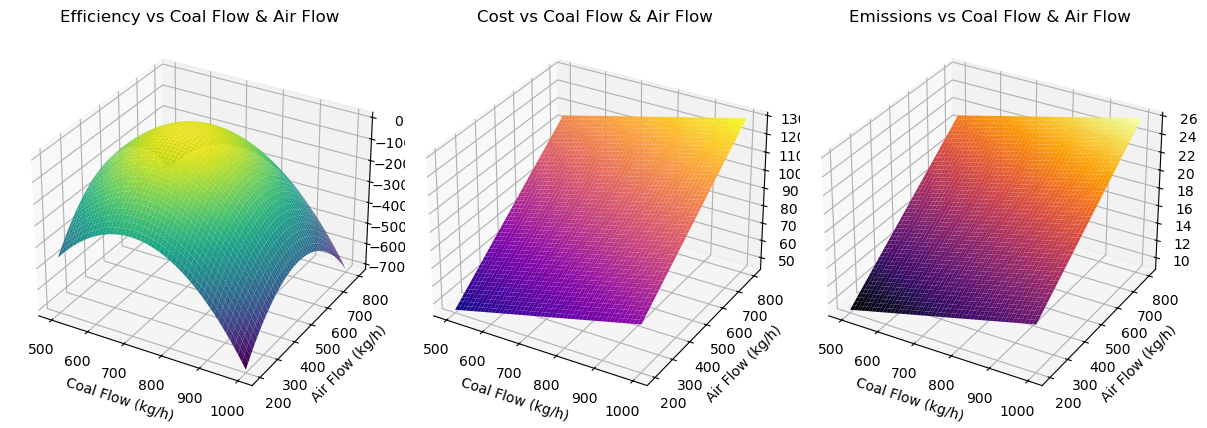

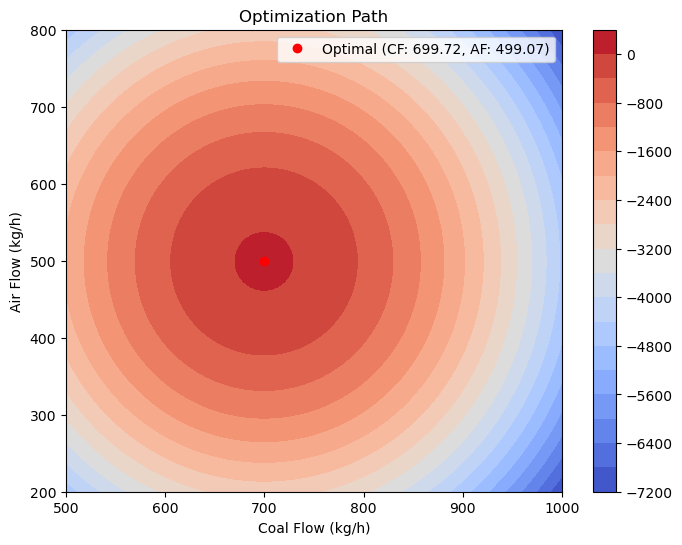

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Step 1: Define the models as previously
def efficiency_model(coal_flow, air_flow):
    return 90 - 0.05 * (coal_flow - 700)**2 - 0.03 * (air_flow - 500)**2

def cost_model(coal_flow, air_flow):
    return 0.05 * coal_flow + 0.1 * air_flow

def emissions_model(coal_flow, air_flow):
    return 0.01 * coal_flow + 0.02 * air_flow

# Step 2: Define the multi-objective function
def multi_objective(params):
    coal_flow, air_flow = params
    efficiency = efficiency_model(coal_flow, air_flow)
    cost = cost_model(coal_flow, air_flow)
    emissions = emissions_model(coal_flow, air_flow)
    
    efficiency_weight = 1.0
    cost_weight = -0.5
    emissions_weight = -0.3
    
    objective_value = (efficiency_weight * efficiency) + (cost_weight * cost) + (emissions_weight * emissions)
    return -objective_value

# Step 3: Perform optimization to find the optimal values
x0_bounds = (500, 1000)
x1_bounds = (200, 800)

result = minimize(multi_objective, [700, 500], bounds=[x0_bounds, x1_bounds], method='L-BFGS-B')
optimal_coal_flow, optimal_air_flow = result.x

# Step 4: Generate grid for visualization
coal_flow_vals = np.linspace(500, 1000, 50)
air_flow_vals = np.linspace(200, 800, 50)
coal_flow_grid, air_flow_grid = np.meshgrid(coal_flow_vals, air_flow_vals)

# Step 5: Calculate objective values (efficiency, cost, and emissions) for the grid
efficiency_grid = efficiency_model(coal_flow_grid, air_flow_grid)
cost_grid = cost_model(coal_flow_grid, air_flow_grid)
emissions_grid = emissions_model(coal_flow_grid, air_flow_grid)

# Step 6: Plot Efficiency vs Coal Flow and Air Flow
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(coal_flow_grid, air_flow_grid, efficiency_grid, cmap='viridis')
ax.set_title("Efficiency vs Coal Flow & Air Flow")
ax.set_xlabel("Coal Flow (kg/h)")
ax.set_ylabel("Air Flow (kg/h)")
ax.set_zlabel("Efficiency (%)")

# Step 7: Plot Cost vs Coal Flow and Air Flow
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(coal_flow_grid, air_flow_grid, cost_grid, cmap='plasma')
ax2.set_title("Cost vs Coal Flow & Air Flow")
ax2.set_xlabel("Coal Flow (kg/h)")
ax2.set_ylabel("Air Flow (kg/h)")
ax2.set_zlabel("Cost")

# Step 8: Plot Emissions vs Coal Flow and Air Flow
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(coal_flow_grid, air_flow_grid, emissions_grid, cmap='inferno')
ax3.set_title("Emissions vs Coal Flow & Air Flow")
ax3.set_xlabel("Coal Flow (kg/h)")
ax3.set_ylabel("Air Flow (kg/h)")
ax3.set_zlabel("Emissions")

plt.tight_layout()
plt.show()

# Step 9: Plot optimization path with contour plot
coal_flow_vals = np.linspace(500, 1000, 100)
air_flow_vals = np.linspace(200, 800, 100)
coal_flow_grid, air_flow_grid = np.meshgrid(coal_flow_vals, air_flow_vals)

# Calculate the objective function values across the grid
objective_vals = np.array([multi_objective([cf, af]) for cf, af in zip(coal_flow_grid.flatten(), air_flow_grid.flatten())])
objective_vals = objective_vals.reshape(coal_flow_grid.shape)

# Plot the contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(coal_flow_grid, air_flow_grid, -objective_vals, cmap='coolwarm', levels=20)
plt.colorbar(cp)
plt.plot(optimal_coal_flow, optimal_air_flow, 'ro', label=f"Optimal (CF: {optimal_coal_flow:.2f}, AF: {optimal_air_flow:.2f})")
plt.title("Optimization Path")
plt.xlabel("Coal Flow (kg/h)")
plt.ylabel("Air Flow (kg/h)")
plt.legend()
plt.show()
